# Building a GAN for creating random handwritten digits
This notebook trains a gan which is able to generate handwirtten digits using the MNIST dataset. This notebook is inspired by [this](https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) blog post.

![](media/gan_mnist.png)

In [28]:
import keras

from keras.models import Sequential

from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop

from tensorflow.examples.tutorials.mnist import input_data

In [40]:
%matplotlib inline
import matplotlib.pylab as plt

from tqdm import tnrange
import numpy as np

# Building the Network

In [30]:
# MNIST dataset consists of 28x28 grayscale images
img_rows = 28
img_cols = 28
channel = 1

## Building the Discriminator

In [31]:
depth = 64
dropout = 0.4

In [32]:
discriminator = Sequential()

input_shape = (img_rows, img_cols, channel)

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same', 
                         activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same',
                         activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same',
                         activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same',
                         activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 512)         3277312   
__________

In [33]:
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)

discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='binary_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])

## Building the Generator

In [34]:
dropout = 0.4
depth = 64+64+64+64
dim = 7

In [35]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(1, 5, padding='same'))
generator.add(Activation('sigmoid'))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_6 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Building the Adverserial
The adversarial model is build by combining both the discriminator and generator

In [37]:
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)

adversarial_model = Sequential()
adversarial_model.add(generator)
adversarial_model.add(discriminator)

adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])

# Train the Network

In [41]:
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, img_rows, img_cols, 1).astype(np.float32)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [44]:
def train(batch_size=256, train_steps=2000):
    discriminator_losses = []
    adversarial_losses = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data
        images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
        # Create noise in range -1 to 1 as input for the generator to generate the fake images
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = generator.predict(noise)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        input_data = np.concatenate((images_train, images_fake))
        input_labels = np.ones([2*batch_size, 1])
        input_labels[batch_size:, :] = 0
        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate more
        input_labels = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        adversarial_loss = adversarial_model.train_on_batch(noise, input_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
    
    return discriminator_losses, adversarial_losses

In [45]:
discriminator_losses, adversarial_losses = train(train_steps=10)

## Plot Training History

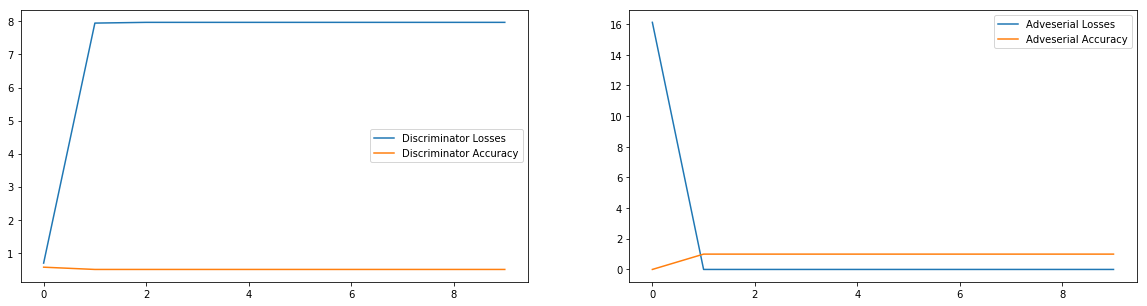

In [58]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(np.array(discriminator_losses)[:, 0], label="Discriminator Losses")
plt.plot(np.array(discriminator_losses)[:, 1], label="Discriminator Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.array(adversarial_losses)[:, 0], label="Adveserial Losses")
plt.plot(np.array(adversarial_losses)[:, 1], label="Adveserial Accuracy")
plt.legend()

# Generating Images

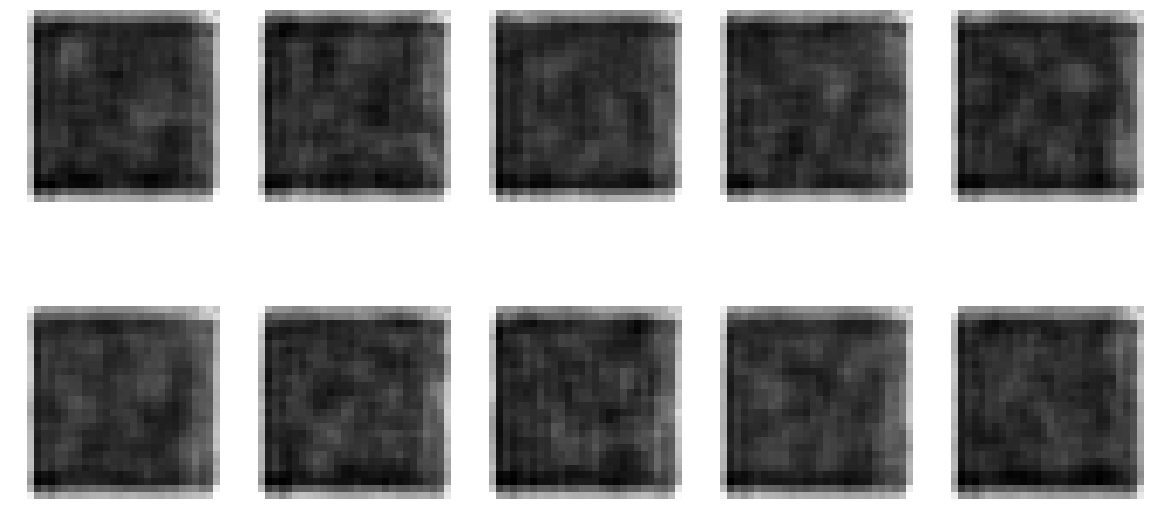

In [76]:
noise = np.random.uniform(-1.0, 1.0, size=[10, 100])
fake_images = generator.predict(noise)

plt.figure(figsize=(20,10))
for i, fake_image in enumerate(fake_images, 1):
    plt.subplot(2, 5, i)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows)), cmap='gray')
    plt.axis('off')